# Homework 4 - Scalability

## CS109B / Stats 121 / AC209B / CSCI E109B

CS109b Staff

March 8, 2018

 ### Enter which version of the course you are enrolled in: 
 

 <span style="color:blue">
I am enrolled in AC209
 </span>

The purpose of this homework is get familiar with scalability and parallelization. 

There are three items to submit:

1. Via Canvas, this populated Jupyter notebook (.ipynb) file
2. Via Canvas, this populated notebook converted to PDF (for inline grading notes)
3. Anonymously share your performance results via this Google form [https://goo.gl/forms/EVrnxj2pzndZvNX22](https://goo.gl/forms/EVrnxj2pzndZvNX22)

## Part 1 - Theory

(a) 30% of your application can be parallelized. It takes 56 seconds to run on your single processor laptop, but only 42 seconds to run on your friend's beefy desktop. How many processors does your friend's machine have? Show your work.


 <div style="color:blue">

This uses Amdahl's law:
$$S_{\text{latency}} (s) = \frac{1}{(1-p) + \frac{p}{s}}$$

$p = 0.3$<br>

$S_{\text{latency}} = \frac{56}{42} \approx 1.33$<br>

Substituting in and solving, $s=6$

<br>There are 6 processors on my friend's machine. 

 </div>

(b) The NVIDIA Telsa K80 in your JupyterHub instances has 4992 cores ([source](http://www.nvidia.com/object/tesla-k80.html)). You have to perform a very large matrix multiplication. Explain what factors would prevent the operation from occurring about 5000 times faster than running the same operation on a single CPU machine. What are the bottlenecks? 

<span style="color:blue">
We are looking for at least three of the following reasons:

* There is overhead in setting up the matrix in memory and invoking the GPU
* The very large matrices may involve more than 5000 elements so there aren't enough processors to handle all matrix elements in parallel.
* The software library in use may not parallelize adequately across all cores.
* Some multiplication operations may finish faster than others (e.g. $x_{i,j} \times 0$) so not all cores will take the same time.
 </span>

## Part 2 - Coding

In this part, we are going to experiment with having code execute in parallel on multiple cores. Let's first determine how many cores a given machine has.

You can run this code on your local machine or on your JupterHub instance. Either is fine.

### 2.1 Setup

In [1]:
from multiprocessing import Process
from multiprocessing import cpu_count
import numpy as np
import time
import random

In [2]:
cpu_count()

8

Every major operating system (MacOS, Windows, Linux) have a means of monitoring CPU utilization across cores.

For MacOS, open `Activity Monitor`, and select CPU usage

For MS-Windows, open `Task Manager`, and look at the performance tab

For Linux, there is the command line `top` command, or for Ubuntu, use `System Monitor`

Verify that the number of cores shown in the appropriate tool corresponds to the number of processors shown above. Leave the CPU monitor window open as it will be used in the subsequent exercises.

**Optional advanced**: your machine may have only half the physical cores listed above. For example, on MacOS, if you go to `Apple` / `About This Mac` / `System Report` only four physical cores could be listed instead of the reported eight. This is due to [hyperthreading](https://en.wikipedia.org/wiki/Hyper-threading). See also [Optimizing Cores](https://macperformanceguide.com/Optimizing-Cores.html)

How many processors are reported above? Does it match what your OS is saying? 

<span style="color:blue">
8, yes. 
 </span>

### 2.2 Sequential Operations

Here we are going to write some Python that executes in parallel across multiple cores. Specifically, we are going to implement prime factorization in regular Python that operates in parallel across multiple cores.

First, let's look at the sequential version:

In [20]:
from sympy import sieve
MAX_NUM = 1000000
PRIMES = list(sieve.primerange(2,MAX_NUM // 2 + 1))


# the number of composite numbers to factor
N = 3000

def calculatePrimeFactors(n):
    primfac = []
    d = 2
    while d*d <= n:
        while (n % d) == 0:
            primfac.append(d)  # supposing you want multiple factors repeated
            n //= d
        d += 1 
    if n > 1:
        primfac.append(n)
    return primfac


print("Starting number crunching")
t0 = time.time()
for i in range(N):
    rand = random.choice(PRIMES) * random.choice(PRIMES) 
    
    factors = calculatePrimeFactors(rand)
    if (i % (N//10) == 0):
        print(factors)
t1 = time.time()
totalTime = t1 - t0
print("Execution Time: {}".format(totalTime))


Starting number crunching
[203947, 264053]
[324301, 376933]
[200513, 453797]
[21407, 178249]
[49261, 152729]
[32441, 42089]
[323149, 382867]
[273433, 440581]
[409573, 498259]
[12007, 369739]
Execution Time: 125.8063850402832



Now, change the line `N = 100` above so the sequential version takes at least a few seconds to run. Increase by orders of magnitude. You may need a value of `N = 1000` on a recent MacBook for example.

What value of N did you choose and how long did it take to run?

<span style="color:blue">
When N=3000, it took about 125.81 seconds
 </span>
 


### 2.3 Parallel Operations

Let's run in parallel across multiple CPUs.

In [21]:
# the number of concurrent processors to use
nProc = 2

# Now let's run it concurrently
def executeProc():
    # Each process is performing a fraction of the load
    # so it has less numbers to factor
    myN = N // nProc
    for i in range(myN):
        #rand = random.randint(20000, 100000000)
        rand = random.choice(PRIMES) * random.choice(PRIMES) 
        
        factors = calculatePrimeFactors(rand)
        if (i % (myN // 10 * nProc) == 0):
            print(factors)        


t0 = time.time()
procs = []
# Here we create our processes and kick them off
for i in range(nProc):
    proc = Process(target=executeProc, args=())
    procs.append(proc)
    proc.start()
# We use the .join() method in order to wait for
# execution to finish for all of our processes
for proc in procs:
    proc.join()
t1 = time.time()
totalTime = t1 - t0
# we print out the total execution time for our 10
# procs.
print("Execution Time: {}".format(totalTime))           

[46889, 447749]
[172169, 393079]
[139891, 292133]
[36563, 296713]
[157543, 274661]
[145283, 449249]
[87427, 118409]
[197971, 496913]
[199399, 371291]
[76367, 387857]
Execution Time: 61.732853174209595


Now, change the line `nProc = 2` above so we use more parallel processors. Increase by 1 or 2 at a time. You may need a value of `nProc = 10` on a recent MacBook for example. Modify the code above to keep track of execution time by number of processes.

What value of nProc produced the fastest time?  

<span style="color:blue">
answer goes here... 
 </span>

In [11]:
# the number of concurrent processors to use
#nProc = 10
N= 3000
# Now let's run it concurrently
def executeProc():
    # Each process is performing a fraction of the load
    # so it has less numbers to factor
    myN = N // nProc
    for i in range(myN):
        #rand = random.randint(20000, 100000000)
        rand = random.choice(PRIMES) * random.choice(PRIMES) 
        
        factors = calculatePrimeFactors(rand)
        if (i % (myN // 10 * nProc) == 0):
            print(factors)        
            
times = []            
for j in range(1,11):
    nProc = j
    
    t0 = time.time()
    procs = []
    # Here we create our processes and kick them off
    for i in range(nProc):
        proc = Process(target=executeProc, args=())
        procs.append(proc)
        proc.start()
    # We use the .join() method in order to wait for
    # execution to finish for all of our processes
    for proc in procs:
        proc.join()
    t1 = time.time()
    totalTime = t1 - t0
    # we print out the total execution time for our 10
    # procs.
    times.append(totalTime)
    print("nProc=",nProc," Execution Time: {}".format(totalTime))           

[284311, 443347]
[35933, 338269]
[238673, 418031]
[181717, 242083]
[86287, 492617]
[86297, 325459]
[205981, 249187]
[349303, 394631]
[51329, 227377]
[59539, 231547]
nProc= 1  Execution Time: 109.11861300468445
[24023, 33349]
[193649, 372901]
[147097, 472573]
[100363, 460903]
[3673, 58567]
[313241, 333539]
[14887, 285421]
[231827, 487363]
[93997, 466273]
[27917, 471503]
nProc= 2  Execution Time: 59.60853815078735
[21563, 259163]
[197269, 279967]
[223019, 309293]
[324893, 389047]
[271, 254753]
[181003, 336997]
[46591, 392963]
[18719, 73459]
[445433, 478343]
[181669, 395891]
[191249, 254699]
[38609, 287887]
nProc= 3  Execution Time: 44.25856828689575
[90749, 258109]
[163171, 452027]
[233279, 420323]
[286673, 462947]
[17467, 63029]
[41221, 100291]
[211151, 222199]
[125821, 168863]
[52489, 297797]
[155027, 281023]
[165811, 272359]
[4441, 270719]
nProc= 4  Execution Time: 36.79765295982361
[12277, 479431]
[36277, 315373]
[22003, 57383]
[202981, 217207]
[235057, 396299]
[74609, 234907]
[13313

In [22]:
times

[109.11861300468445,
 59.60853815078735,
 44.25856828689575,
 36.79765295982361,
 38.28595519065857,
 38.49188184738159,
 41.33573293685913,
 41.799692153930664,
 41.23146605491638,
 42.01186013221741]

<span style="color:blue">
Here I selected N=3000 (to avoid the noise of other processes running on my machine) and nProc=10. As expected the fastest time is when nProc=4.
</span>

### 2.4 - Plotting and Interpretation

(a) Plot the execution time vs number of processes from 1 to nProc + 4 (ie. if nProc == 10 was optimal, plot from 1 to 14 processes). 

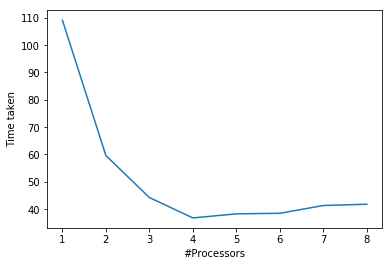

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np.arange(1,9)
exec_time = times[0:8]

plt.plot(x,exec_time);
plt.xlabel('#Processors')
plt.ylabel('Time taken');

(b) According to your OS's CPU monitor, were all cores in use?

<span style="color:blue">
All cores, including virtual cores should have been in use. 
 </span>

(c) Why was this optimal based on the number of cores that you have? Why does a higher number of processes not speed things up? How many physical cores do you suspect your machine has vs the number reported by `cpu_count()` in 2.1?

<span style="color:blue">
Attempting to parallelize for more than the supplied hardware only adds overhead and does not reduce computation time.  My machine has 4 physical cores (System Report on MacOS), where as cpu_count() reports 8. This is because there are 8 logical processors. 
 </span>

### Part 3 - AC209 Problem

Implement prime factorization using `numpy`.

Hint: the book Numpy Cookbook available through Hollis may help you.

Use your function and the same number of `N` sequential cases as above. Time the result.

* How long did numpy take vs the sequential and parallel versions?
* Was your implementation faster than numpy?
* Was numpy using multiple cores or not?

**For all students:**
Don't forget to post your results to  [https://goo.gl/forms/EVrnxj2pzndZvNX22](https://goo.gl/forms/EVrnxj2pzndZvNX22)

In [19]:
LIM = 10 ** 6

def factor(n):
   #1. Create array of trial values
    a = np.ceil(np.sqrt(n))
    lim = min(n, LIM)
    a = np.arange(a, a + lim)
    b2 = a ** 2 - n

    #2. Check whether b is a square
    fractions = np.modf(np.sqrt(b2))[0]

    #3. Find 0 fractions
    indices = np.where(fractions == 0)

    #4. Find the first occurrence of a 0 fraction
    a = np.ravel(np.take(a, indices))[0]
              # Or a = a[indices][0]

    a = int(a)
    b = np.sqrt(a ** 2 - n) 
    b = int(b)
    c = a + b
    d = a - b

    if c == 1 or d == 1:
        return  

    #print(c, d)
    return(c,d)
    factor(c)
    factor(d)


t0 = time.time()
list2 = []
for i in range(N):
    rand = random.choice(PRIMES) * random.choice(PRIMES) 
    x = factor(rand)
    if x is not None:
        list2.append(x)

t1 = time.time()
totalTime = t1 - t0
print("Execution Time: {}".format(totalTime))   

Execution Time: 41.503756046295166


<span style="color:blue">
Numpy Implementation took - 41.50 seconds,  <BR/> 
For sequential processing it took - 109.12 seconds, <BR/> 
For nProc = 4 (our fastest) it took - 36.8, seconds,<BR/>
For all of the above N=3000<BR/>
Numpy implementation is certainly better than sequential processing. Numpy does seem to utlize multiple cores. 
 </span>
 